# Ensemble Learning [intro]

`wisdom of the crowd`<br>

if you aggregate the predictions of a group of predictors (classifiers or regressors), you will often get a better prediction than with any individual predictor. <br>

ensemble = "a group of predictors"<br>
this technique is called `Ensemble Learning`

**ensemble of Decision Trees = Random Forest**

some of the classification approaches using ensemble methods:

## Voting Classifiers:
**(`hard voting` classifier)**

aggregate of the predictions of each of the classifiers.

`whichever class gets the most votes out of all the predicted classes of all classifiers, is marked as the predicted class by the Voting Classifier.`


[NOTE]: everytime the classifiers you built are performing as `weak learners`, a Voting Classifier built out of weak learners always performs significantly better!


Lets say, you have a slightly biased coin that gives head 51% of the time (prob of being a heads) and just 49% of times the tails coming up, in every toss.

if you toss it 1000 times,<br>
510 heads<br>
490 tails<br>


`the more you toss the coin, the higher the probability of heads coming up increases`


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


heads_proba = 0.51

# tossing coin in series of 10 attempts, for a total of 1000 times
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)

cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

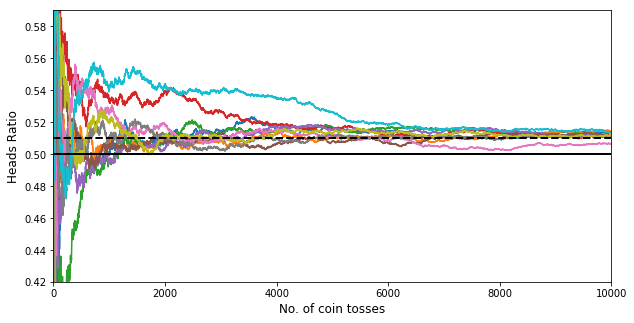

In [7]:
plt.figure(figsize=(10,5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", linewidth=2, label="50%")
plt.xlabel("No. of coin tosses", fontsize=12)
plt.ylabel("Heads Ratio", fontsize=12)
plt.axis([0, 10000, 0.42, 0.59])
plt.show()

**Similarly, suppose you built an ensemble containing 1000 classifiers that are individually correct for only about 51% of the time (barely better than a random guess). If you predict the majority voted class, you can achieve an accuracy of close to 75%**

`soft voting` classifier basically take into consideration the class probabilities. <br>
You basically predict the class that has the highest probability across all the 1000 classifiers. <br>
[NOTE] for this to happen you need to make sure that each of your predictor has `predict_proba()` decision making method.

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
# make moons dataset

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


log_clf = LogisticRegression(random_state=29)
rf_clf = RandomForestClassifier(n_estimators=10, random_state=29)
svm_clf = SVC(random_state=29)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)],
                             voting="hard")

In [12]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=29, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...rbf', max_iter=-1, probability=False, random_state=29,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [13]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.888


In [15]:
svm_clf = SVC(probability=True, random_state=29)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)],
                             voting="soft")

for clf in (log_clf, rf_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.904


# Bagging & Pasting Ensembles

As we discussed above, one way to get a diverse set of classifiers is to use very different different training algorithms.

Another approach is to use the same training algo for every predictor but train them on diff diff random subsets of the training set.

When sampling is performed with replacement ---> `Bagging` (by setting out the hyperparameter `bootstrap`)<br>
When sampling is performed without replacement ---> `Pasting`<br>

Both bagging & pasting allow training instances to be sampled several times across multiple predictors.

But only bagging allows training instances to be sampled several times for the same predictor.

The `aggregatation function` is actually the `statistical mode` operation (i.e. the most freq prediction, just like hard voting classifier) `for classification` and the `average for regression`.

**Each individual predictor has a higher bias than it it were trained on the original training set but the aggregation somewhat reduces both the bias and variance.**

So generally, the net result is that the ensemble has a similar bias but a lower variance than any single predictor trained on the training set.

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=29), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=29
)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

In [17]:
accuracy_score(y_test, y_pred)

0.904

In [19]:
tree_clf = DecisionTreeClassifier(random_state=29)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


In [21]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'bs', alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'g^', alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14, rotation=0)

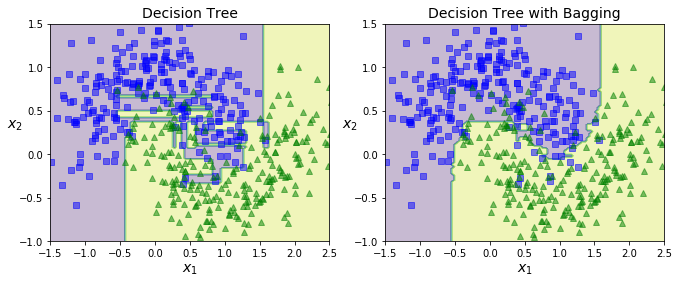

In [22]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree with Bagging", fontsize=14)
plt.show()

## Out of Bag (oob) Evaluation

`since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross validation. We can evaluate the emsemble itself by averaging out oob evaluations of each predictor.`

hyperparameter: `oob_score=True` when creating the Bagging Classifier

In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.9013333333333333

According to this oob evaluation, BaggingClassifier is likely to achieve about 90% accuracy on testing set.

In [24]:
# lets verify
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

In [25]:
bag_clf.oob_decision_function_

array([[0.33333333, 0.66666667],
       [0.32065217, 0.67934783],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.0960452 , 0.9039548 ],
       [0.34883721, 0.65116279],
       [0.01456311, 0.98543689],
       [0.98863636, 0.01136364],
       [0.96634615, 0.03365385],
       [0.78350515, 0.21649485],
       [0.        , 1.        ],
       [0.77435897, 0.22564103],
       [0.84065934, 0.15934066],
       [0.96987952, 0.03012048],
       [0.03846154, 0.96153846],
       [0.        , 1.        ],
       [0.97191011, 0.02808989],
       [0.91836735, 0.08163265],
       [0.99450549, 0.00549451],
       [0.04      , 0.96      ],
       [0.32323232, 0.67676768],
       [0.92134831, 0.07865169],
       [1.        , 0.        ],
       [0.98305085, 0.01694915],
       [0.        , 1.        ],
       [0.99459459, 0.00540541],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.61616162, 0.38383838],
       [0.

## Random Patches & Random Subspaces

`The Bagging Classifier also supports sampling the features as well`

two hyperparameters to control these: `max_features` and `bootstrap_features`

they work the same way as `max_samples` and `bootstrap` but for the features' sampling instead of sampling of the instances.

Sampling both training instances and features is called as **Random Patches method**

Keeping all the training instances (i.e. `bootstrap=False` and `max_samples=1`) but sampling the features (i.e. `bootstrap_features=True` and/or `max_features` smaller than 1)is what we call as **Random Subspaces method**.

## Random Forest

**Random Forest** is basically an ensemble of Decision Trees, trained via bagging method (sometimes even pasting), typically with `max_samples` set out to the size of the actual training set.

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

In [27]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.912

almost identical prediction.


**creating identical models as above usign an bagging ensemble appraoche**

In [29]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1, bootstrap=True, n_jobs=-1
)

## Extra Trees
(short form of **Extremely Randomized Trees**)

`at each node only a random subset of features is considered when growing a tree in Random Forest. It is possible to make trees more random by using random thresholds for each features rather than searching for the best possible threshold (like how regular Decision Trees do).`

use Scikit-Learn's `ExtraTreesClassifier` class for classification & `ExtraTreesRegressor` class for regression like problem statements.

# Feature Importance

Scikit-Learn measures a feature's importance `by looking at how much the tree nodes that use that feature reduce the impurity on average (across all the trees in the forest)`. Actually it is a `weighted average`, where each node's weight is equal to the number of training samples that are associated with it.

**Scikit Learn scores these automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1**

`feature_importances_`

In [33]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=29)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.1014345057232787
sepal width (cm) 0.023670882533759072
petal length (cm) 0.43423446385220177
petal width (cm) 0.44066014789076063


# Boosting

**[idea]**`combining several weak learners into one strong learner`

`The general idea is to train poredictors sequentially, each trying to correct its predecessor.`

2 most commonly approaches in boosting are:
- AdaBoost
- Gradient Boosting


## AdaBoost

One way for a new predictor to correct its predecessor is to focus more on the cases the predecessor underfitted. This again would in turn lead to another predictor focusing more on these hard cases, and this technique of boosting is called as **AdaBoost** method.


`the sequential learning technique is somewhat similar to the Gradient Descent appraoch, except for tweaking a single predictor's parameters so as to minimize the cost function, AdaBoost adds a new predictor every time to the ensemble to gradually make it better.`

`sequential learning techniques can't parallalized (habve to be trained sequentially) == more time while training`

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    learning_rate=0.5, random_state=29
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=29)

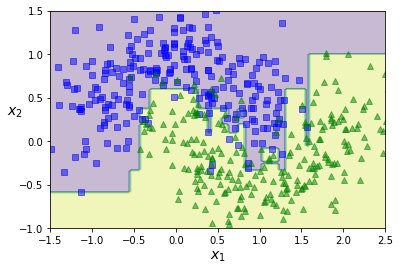

In [35]:
plot_decision_boundary(ada_clf, X, y)

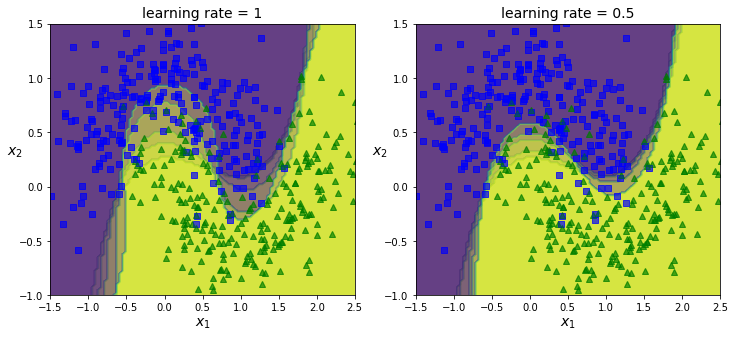

In [42]:
m = len(X_train)

plt.figure(figsize=(12,5))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.5, random_state=29)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning rate = {}".format(learning_rate), fontsize=14)
        
plt.show()

## Gradient Boosting

`Trained sequentially like AdaBoost. However, instead of tweaking the instance weights at each iteration like AdaBoost, it actually tries to fit the new predictor to the residual errors made by the previous predictor thereby reducing the overall residual error of the ensemble model`

**GBRT**

In [43]:
np.random.seed(29)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.5 * np.random.randn(100)

In [50]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=29)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=29, splitter='best')

In [51]:
# for the next predictor in sequ (for boosting)

y2 = y - tree_reg1.predict(X) # residual errors

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=29)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=29, splitter='best')

In [52]:
y3 = y2 - tree_reg2.predict(X)

tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=29)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=29, splitter='best')

In [47]:
# new testin instance
X_new = np.array([[0.8]])

In [53]:
y_pred = sum(t.predict(X_new) for t in (tree_reg, tree_reg2, tree_reg3))

In [54]:
y_pred

array([0.61515247])

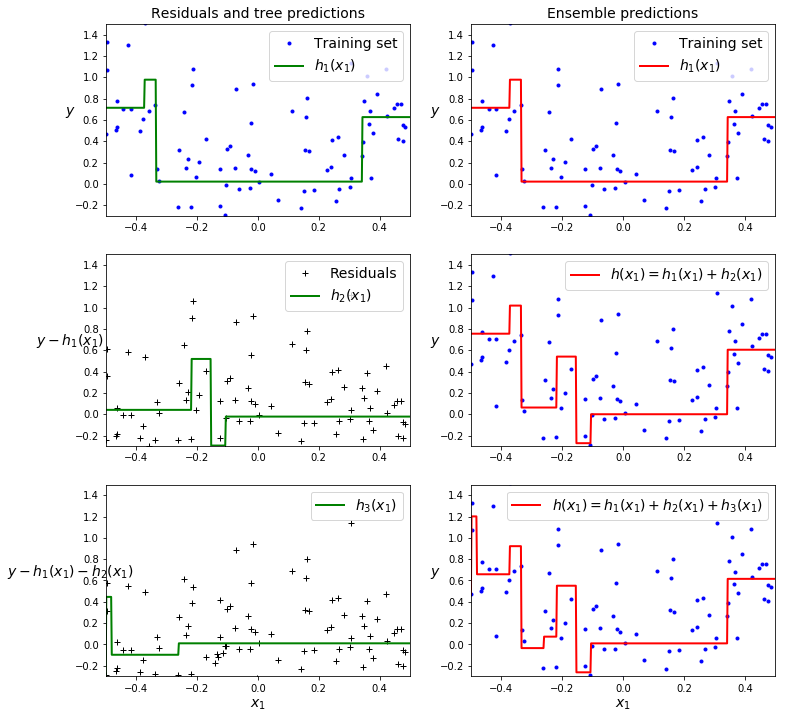

In [62]:
def plot_predictions(regressors, X, y, axes, data_style="b.", style="r-", data_label=None, label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper right", fontsize=14)
    plt.axis(axes)
    
    
plt.figure(figsize=(12,12))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.3, 1.5], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=14, rotation=0)
plt.title("Residuals and tree predictions", fontsize=14)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.3, 1.5], label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=14, rotation=0)
plt.title("Ensemble predictions", fontsize=14)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.3, 1.5], label="$h_2(x_1)$", style="g-", data_style="k+", 
                 data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=14, rotation=0)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.3, 1.5], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=14, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.3, 1.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=14, rotation=0)
plt.xlabel("$x_1$", fontsize=14)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.3, 1.5], 
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.ylabel("$y$", fontsize=14, rotation=0)
plt.xlabel("$x_1$", fontsize=14)

plt.show()

## XGBoost

`XGboost provides a parallel tree boosting approach`<br>

**basically an optimized distributed gradient boosting library**

## Stacking

short for **Stacked Generalization**

**Ques**: instead of using functions like hard voting, etc. to aggregate the predictions of all predictors in any ensemble, why don't we train a model to perform this aggregation?

[idea]: the final predictor (also called as `meta learner` or `blenders`) takes these predictions of all the previous predictors as inputs to make its final prediction.
